# VGGT Architecture Exploration

**Goal:** Understand every component of VGGT (CVPR 2025 Best Paper) before integrating its geometry features into the 3D-VLA thesis pipeline.

**Paper:** *Visual Geometry Grounded Transformer* — Facebook Research  
**Model:** `facebook/VGGT-1B` (1B params)  
**Kernel:** uv-managed Python 3.12 env (`uv run jupyter lab`)

---
## Table of Contents
1. [Setup & Imports](#1)
2. [Model Load & Parameter Counts](#2)
3. [Load Example Images](#3)
4. [Full Forward Pass](#4)
5. [Depth & Point Cloud Visualization](#5)
6. [DPT Head Deep-Dive](#6)
7. [DPT Disabled Experiment](#7)
8. [Camera Pose Encoding](#8)
9. [Thesis Notes & Summary](#9)

---
## 1. Setup & Imports <a id='1'></a>

In [1]:
import sys, os

# Add VGGT source to path
REPO_ROOT = os.path.abspath("..")
VGGT_PATH = os.path.join(REPO_ROOT, "external", "VGGT")
if VGGT_PATH not in sys.path:
    sys.path.insert(0, VGGT_PATH)

import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Device: prefer MPS (Apple Silicon), then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"torch: {torch.__version__}")
print(f"device: {device}")
print(f"VGGT on path: {os.path.exists(os.path.join(VGGT_PATH, 'vggt'))}")

torch: 2.10.0
device: mps
VGGT on path: True


---
## 2. Model Load & Parameter Counts <a id='2'></a>

VGGT consists of:
- **Aggregator** — DINOv2-style ViT-L backbone + cross-frame attention
- **CameraHead** — 4-iteration refinement of [T | quat | FoV] from camera tokens
- **DPTHead (depth)** — dense depth + confidence, output_dim=2
- **DPTHead (point)** — dense 3D world points + confidence, output_dim=4
- **TrackHead** — point tracking (skipped here; requires query_points)

In [2]:
from vggt.models.vggt import VGGT

# Download from HuggingFace Hub (~4 GB, cached after first run)
print("Loading VGGT-1B from HuggingFace Hub...")
model = VGGT.from_pretrained("facebook/VGGT-1B")
model = model.to(device)
model.eval()
print("Model loaded.")

Loading VGGT-1B from HuggingFace Hub...


/Users/lucamac/Coding/Master-Thesis-3D-VLA/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded.


In [3]:
def count_params(module):
    if module is None:
        return 0
    return sum(p.numel() for p in module.parameters())

total = count_params(model)
components = {
    "aggregator":   count_params(model.aggregator),
    "camera_head":  count_params(model.camera_head),
    "depth_head":   count_params(model.depth_head),
    "point_head":   count_params(model.point_head),
    "track_head":   count_params(model.track_head),
}

print(f"{'Component':<20} {'Params':>12} {'Share':>8}")
print("-" * 42)
for name, n in components.items():
    print(f"{name:<20} {n:>12,} {n/total*100:>7.1f}%")
print("-" * 42)
print(f"{'TOTAL':<20} {total:>12,} {'100.0%':>8}")

Component                  Params    Share
------------------------------------------
aggregator            909,112,320    72.4%
camera_head           216,174,610    17.2%
depth_head             32,654,562     2.6%
point_head             32,654,628     2.6%
track_head             65,941,396     5.2%
------------------------------------------
TOTAL                1,256,537,516   100.0%


---
## 3. Load Example Images <a id='3'></a>

In [4]:
import glob
from vggt.utils.load_fn import load_and_preprocess_images

# Use kitchen scene (5 views)
img_dir = os.path.join(VGGT_PATH, "examples", "kitchen", "images")
img_paths = sorted(glob.glob(os.path.join(img_dir, "*.png")))[:5]
print(f"Found {len(img_paths)} images: {[os.path.basename(p) for p in img_paths]}")

# Preprocess: resize to 518px wide, center-crop, normalize to [0,1]
images = load_and_preprocess_images(img_paths, mode="crop")  # [S, 3, H, W]
print(f"Images tensor shape: {images.shape}  dtype: {images.dtype}")
print(f"Value range: [{images.min():.3f}, {images.max():.3f}]")

Found 5 images: ['00.png', '01.png', '02.png', '03.png', '04.png']
Images tensor shape: torch.Size([5, 3, 350, 518])  dtype: torch.float32
Value range: [0.000, 1.000]


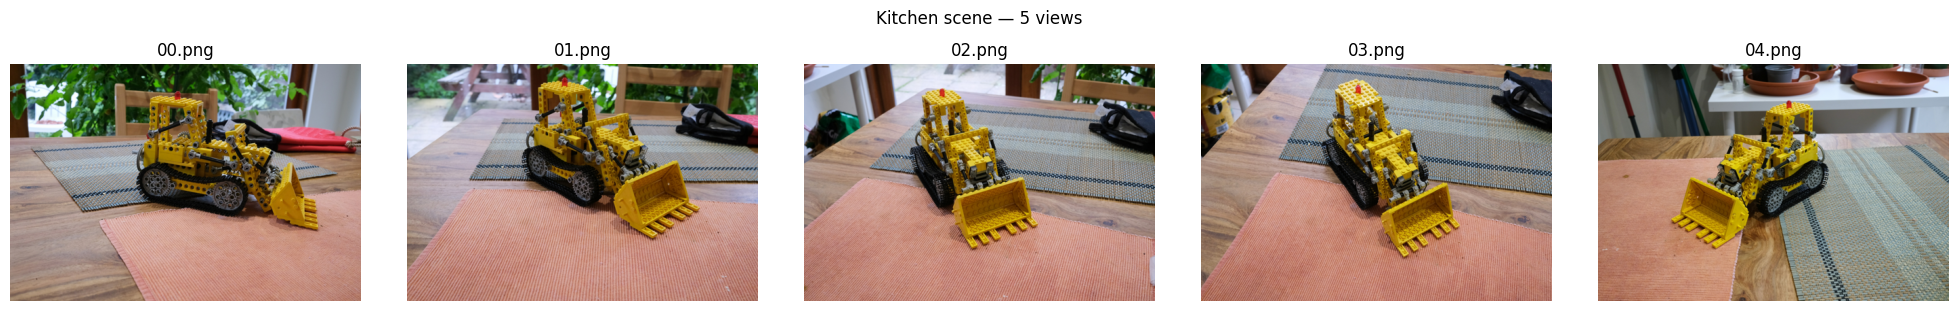

In [5]:
S = images.shape[0]
fig, axes = plt.subplots(1, S, figsize=(4 * S, 3))
for i, ax in enumerate(axes):
    img_np = images[i].permute(1, 2, 0).numpy()
    ax.imshow(img_np)
    ax.set_title(os.path.basename(img_paths[i]))
    ax.axis("off")
plt.suptitle("Kitchen scene — 5 views", y=1.02)
plt.tight_layout()
plt.show()

---
## 4. Full Forward Pass <a id='4'></a>

VGGT forward signature:
```python
predictions = model(images)  # images: [S, 3, H, W]  →  adds batch dim internally
```
Output keys (all tensors have batch dim B=1):
| Key | Shape | Description |
|-----|-------|-------------|
| `pose_enc` | [B, S, 9] | absT + quaR + FoV (last iter) |
| `pose_enc_list` | list[4] of [B, S, 9] | all 4 CameraHead iterations |
| `depth` | [B, S, H, W, 1] | predicted depth |
| `depth_conf` | [B, S, H, W] | depth confidence |
| `world_points` | [B, S, H, W, 3] | 3D world coords |
| `world_points_conf` | [B, S, H, W] | point confidence |
| `images` | [B, S, 3, H, W] | input images (inference only) |

In [6]:
import time

images_dev = images.to(device)

t0 = time.time()
with torch.no_grad():
    predictions = model(images_dev)
elapsed = time.time() - t0

print(f"Inference time: {elapsed:.2f}s  ({elapsed/S:.2f}s per frame)\n")
print(f"{'Key':<25} {'Shape':>30}")
print("-" * 57)
for k, v in predictions.items():
    if isinstance(v, torch.Tensor):
        print(f"{k:<25} {str(tuple(v.shape)):>30}")
    elif isinstance(v, list):
        print(f"{k:<25} {'list[' + str(len(v)) + '] of ' + str(tuple(v[0].shape)):>30}")

/Users/lucamac/Coding/Master-Thesis-3D-VLA/external/VGGT/vggt/models/vggt.py:65: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Inference time: 14.12s  (2.82s per frame)

Key                                                Shape
---------------------------------------------------------
pose_enc                                       (1, 5, 9)
pose_enc_list                       list[4] of (1, 5, 9)
depth                                (1, 5, 350, 518, 1)
depth_conf                              (1, 5, 350, 518)
world_points                         (1, 5, 350, 518, 3)
world_points_conf                       (1, 5, 350, 518)
images                               (1, 5, 3, 350, 518)


In [7]:
# Camera pose encoding breakdown: [T(3) | quat(4) | FoV_h FoV_w(2)]
pose = predictions["pose_enc"]  # [1, S, 9]
print("Camera pose encodings (frame 0):")
print(f"  T   (translation): {pose[0, 0, :3].cpu().numpy()}")
print(f"  quat (rotation):   {pose[0, 0, 3:7].cpu().numpy()}")
print(f"  FoV_h, FoV_w (rad): {pose[0, 0, 7:].cpu().numpy()}")
print(f"  FoV_h, FoV_w (deg): {torch.rad2deg(pose[0, 0, 7:]).cpu().numpy()}")

Camera pose encodings (frame 0):
  T   (translation): [-1.6888807e-06 -1.7145569e-05  8.9401110e-06]
  quat (rotation):   [-2.1376487e-05  1.0563169e-05 -1.2160588e-05  1.0000051e+00]
  FoV_h, FoV_w (rad): [0.6353898 0.9062682]
  FoV_h, FoV_w (deg): [36.405155 51.925343]


---
## 5. Depth & Point Cloud Visualization <a id='5'></a>

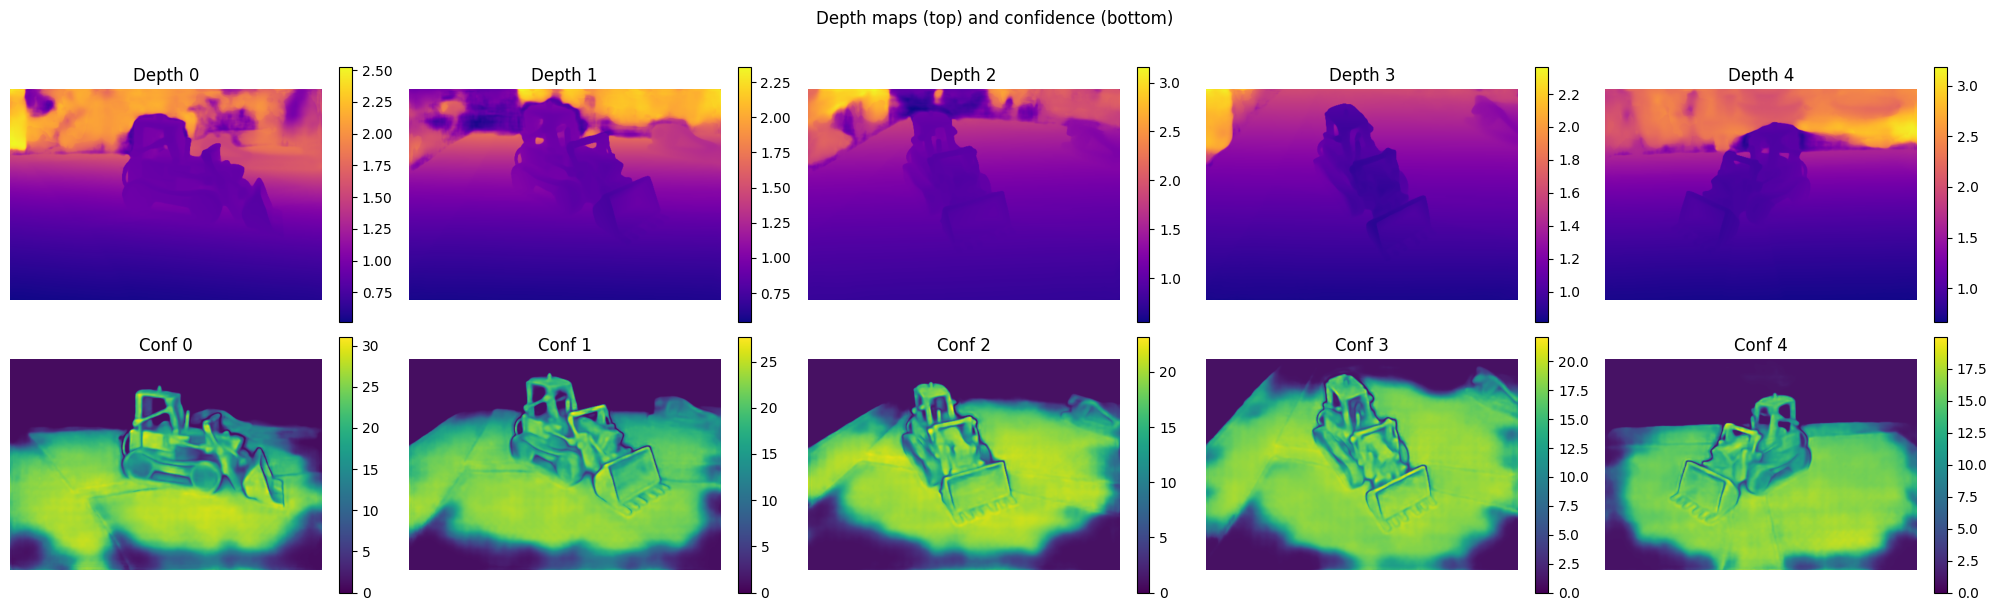

depth: torch.Size([1, 5, 350, 518])  depth_conf: torch.Size([1, 5, 350, 518])
Depth matches image H,W: True


In [8]:
# Depth maps + confidence per frame
# depth: [B, S, H, W, 1]  depth_conf: [B, S, H, W]
depth = predictions["depth"].squeeze(-1).cpu()       # [1, S, H, W]
depth_conf = predictions["depth_conf"].cpu()         # [1, S, H, W]

fig, axes = plt.subplots(2, S, figsize=(4 * S, 6))
for i in range(S):
    d = depth[0, i].numpy()
    c = depth_conf[0, i].numpy()

    im0 = axes[0, i].imshow(d, cmap="plasma")
    axes[0, i].set_title(f"Depth {i}")
    axes[0, i].axis("off")
    plt.colorbar(im0, ax=axes[0, i], fraction=0.046)

    im1 = axes[1, i].imshow(c, cmap="viridis", vmin=0)
    axes[1, i].set_title(f"Conf {i}")
    axes[1, i].axis("off")
    plt.colorbar(im1, ax=axes[1, i], fraction=0.046)

plt.suptitle("Depth maps (top) and confidence (bottom)", y=1.01)
plt.tight_layout()
plt.show()

print(f"depth: {depth.shape}  depth_conf: {depth_conf.shape}")
print(f"Depth matches image H,W: {tuple(depth.shape[-2:]) == tuple(images.shape[-2:])}")

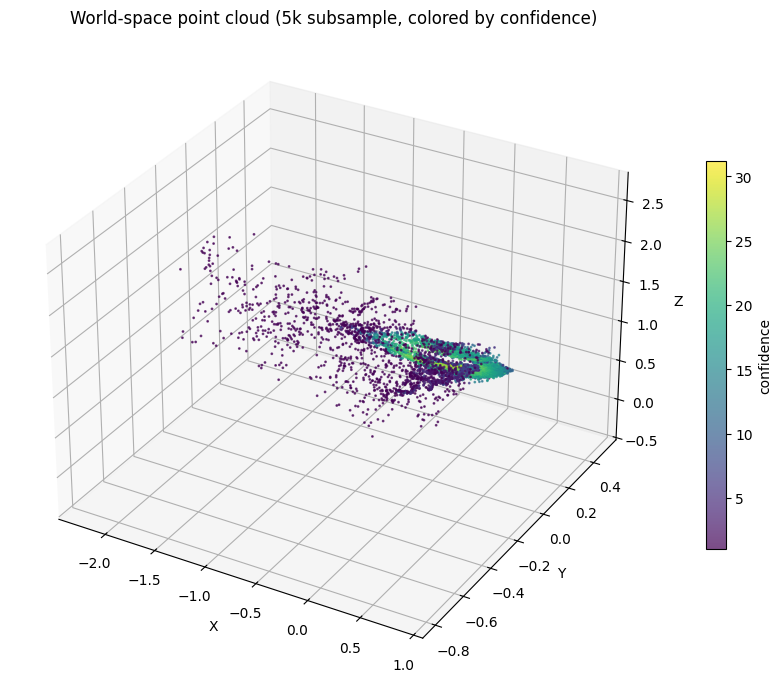

In [9]:
# 3D point cloud — subsample 5k points from all frames, colored by confidence
# world_points: [B, S, H, W, 3]  world_points_conf: [B, S, H, W]
pts3d = predictions["world_points"].cpu()         # [1, S, H, W, 3]
pts_conf = predictions["world_points_conf"].cpu() # [1, S, H, W]

pts_flat = pts3d[0].reshape(-1, 3).numpy()        # [S*H*W, 3]
conf_flat = pts_conf[0].reshape(-1).numpy()       # [S*H*W]

# Subsample 5k points (uniform random)
rng = np.random.default_rng(42)
idx = rng.choice(len(pts_flat), size=min(5000, len(pts_flat)), replace=False)
pts_sub = pts_flat[idx]
conf_sub = conf_flat[idx]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(pts_sub[:, 0], pts_sub[:, 1], pts_sub[:, 2],
                c=conf_sub, cmap="viridis", s=1, alpha=0.7)
plt.colorbar(sc, ax=ax, label="confidence", shrink=0.6)
ax.set_title("World-space point cloud (5k subsample, colored by confidence)")
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

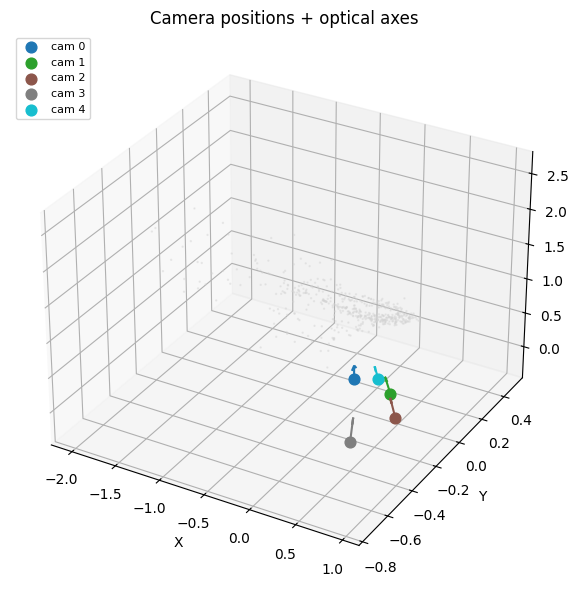

In [10]:
# Camera frustum plot — visualize camera positions across all frames
from vggt.utils.pose_enc import pose_encoding_to_extri_intri

H_img, W_img = images.shape[-2], images.shape[-1]
extrinsics, intrinsics = pose_encoding_to_extri_intri(
    predictions["pose_enc"].cpu(), image_size_hw=(H_img, W_img)
)  # extrinsics: [1, S, 3, 4]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")

# Plot point cloud (low density)
idx2 = rng.choice(len(pts_flat), size=500, replace=False)
ax.scatter(*pts_flat[idx2].T, c="lightgray", s=0.5, alpha=0.4)

# Plot camera centers
colors = plt.cm.tab10(np.linspace(0, 1, S))
for i in range(S):
    # Camera center in world space: C = -R^T @ t
    R = extrinsics[0, i, :3, :3].numpy()  # [3, 3]
    t = extrinsics[0, i, :3, 3].numpy()   # [3]
    C = -R.T @ t                           # world-space camera center
    # Camera optical axis direction (column 2 of R^T)
    fwd = R.T[:, 2]
    ax.scatter(*C, color=colors[i], s=60, zorder=5, label=f"cam {i}")
    ax.quiver(*C, *fwd * 0.2, color=colors[i], linewidth=1.5)

ax.set_title("Camera positions + optical axes")
ax.legend(loc="upper left", fontsize=8)
ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

---
## 6. DPT Head Deep-Dive <a id='6'></a>

### Architecture summary

The DPT head fuses **4 intermediate ViT layers** (indices 4, 11, 17, 23) into a dense prediction:

```
aggregated_tokens[layer_idx]  →  LayerNorm  →  reshape [BS, C, ph, pw]
  └─ projects[i]:  Conv2d(2048 → oc_i, 1×1)   # project to lower dim
     └─ pos_embed +
        resize_layers[i]:  ConvTranspose2d ×4 / ×2 / Identity / Conv↓2
           └─ scratch.layerN_rn: Conv2d(oc_i → 256, 3×3)

refinenet4(layer4_rn)               → upsample ×2
refinenet3(^, layer3_rn)            → upsample ×2
refinenet2(^, layer2_rn)            → upsample ×2
refinenet1(^, layer1_rn)            → upsample ×2
  → output_conv1: Conv2d(256 → 128, 3×3)
  → interpolate to (H, W)
  → output_conv2: Conv2d(128→32→output_dim, 3×3 → 1×1)
  → activate_head: split → value activation + confidence activation
```

For `depth_head`: `output_dim=2`, activation=`exp`, conf_activation=`expp1`  
For `point_head`: `output_dim=4`, activation=`inv_log`, conf_activation=`expp1`

Intermediate layer indices and their upsampling:
| idx | layers[idx] | resize | scale vs patch grid |
|-----|-------------|--------|---------------------|
| 4   | early       | ×4 ConvTranspose | 4× (finest) |
| 11  | mid-early   | ×2 ConvTranspose | 2× |
| 17  | mid-late    | Identity         | 1× |
| 23  | late        | Conv stride 2 downsampled | 0.5× (coarsest) |

In [11]:
# Register hooks on DPT depth_head intermediate projections to capture shapes
hook_outputs = {}

def make_hook(name):
    def hook(module, inp, out):
        hook_outputs[name] = out.detach().cpu()
    return hook

handles = []
dh = model.depth_head
for i, proj in enumerate(dh.projects):
    h = proj.register_forward_hook(make_hook(f"project_{i}"))
    handles.append(h)
for i, rl in enumerate(dh.resize_layers):
    h = rl.register_forward_hook(make_hook(f"resize_{i}"))
    handles.append(h)

with torch.no_grad():
    _ = model(images_dev)

# Remove hooks
for h in handles:
    h.remove()

print("DPT depth_head intermediate feature shapes (B*S, C, H, W):")
print(f"{'Name':<15} {'Shape':>25}")
print("-" * 42)
for name in sorted(hook_outputs):
    print(f"{name:<15} {str(tuple(hook_outputs[name].shape)):>25}")

DPT depth_head intermediate feature shapes (B*S, C, H, W):
Name                                Shape
------------------------------------------
project_0                (5, 256, 25, 37)
project_1                (5, 512, 25, 37)
project_2               (5, 1024, 25, 37)
project_3               (5, 1024, 25, 37)
resize_0               (5, 256, 100, 148)
resize_1                 (5, 512, 50, 74)
resize_2                (5, 1024, 25, 37)
resize_3                (5, 1024, 13, 19)


In [12]:
# PCA of patch tokens from the last aggregator layer → RGB visualization
# Shows what the backbone has learned before the DPT head

# Capture aggregated_tokens_list AND patch_start_idx from aggregator forward
agg_tokens_captured = []
orig_forward = model.aggregator.forward

def patched_agg_forward(*args, **kwargs):
    result = orig_forward(*args, **kwargs)
    agg_tokens_captured.append(result)  # (aggregated_tokens_list, patch_start_idx)
    return result

model.aggregator.forward = patched_agg_forward
with torch.no_grad():
    _ = model(images_dev)
model.aggregator.forward = orig_forward

agg_tokens_list, patch_start_idx = agg_tokens_captured[0]
print(f"Number of layers captured: {len(agg_tokens_list)}")
print(f"patch_start_idx: {patch_start_idx}  (1 camera token + {patch_start_idx-1} register tokens)")
print(f"Token tensor shape (last layer): {agg_tokens_list[-1].shape}")

Number of layers captured: 24
patch_start_idx: 5  (1 camera token + 4 register tokens)
Token tensor shape (last layer): torch.Size([1, 5, 930, 2048])


patch_tokens shape: torch.Size([5, 925, 2048])  (expected [5, 925, 2048])


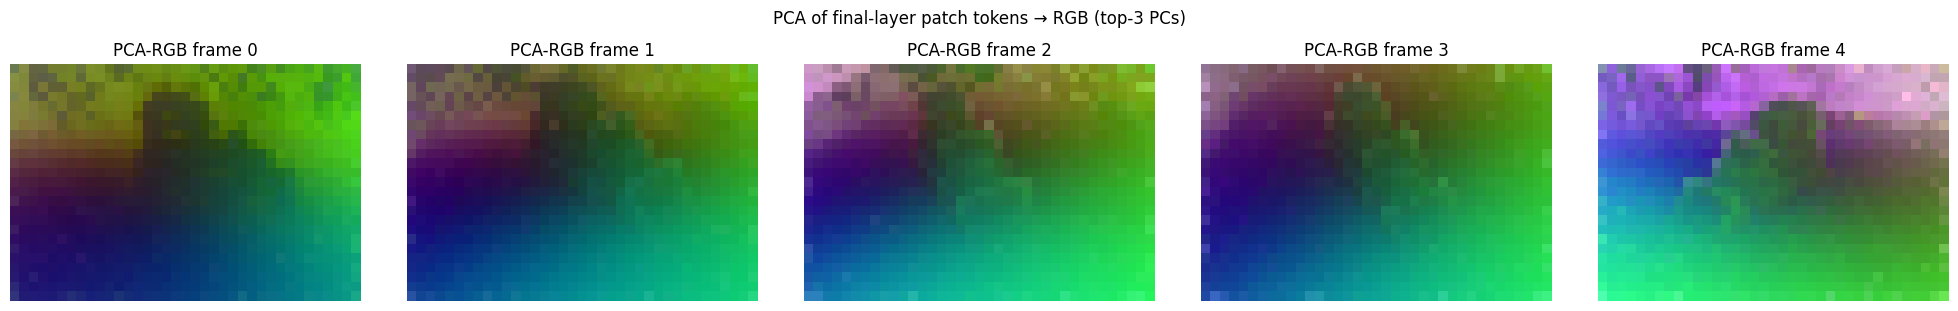

Explained variance ratio (top-3): [37.05187   12.5762825  9.803852 ]


In [13]:
# PCA of patch tokens from the final layer → RGB visualization per frame
# patch_start_idx = 5: camera token at 0, then 4 register tokens, then patch tokens

tokens_last = agg_tokens_list[-1]  # [1, S, N_tokens, C]
_, S_t, N, C = tokens_last.shape
H_p = images.shape[-2] // 14
W_p = images.shape[-1] // 14
patch_tokens = tokens_last[0, :, patch_start_idx:patch_start_idx + H_p * W_p, :]  # [S, H_p*W_p, C]

print(f"patch_tokens shape: {patch_tokens.shape}  (expected [{S_t}, {H_p*W_p}, {C}])")

# Flatten all frames for PCA
X = patch_tokens.reshape(-1, C).float().cpu().numpy()  # [S*H_p*W_p, C]
X -= X.mean(0, keepdims=True)

# SVD for top-3 components
U, s, Vt = np.linalg.svd(X, full_matrices=False)
pca_feats = (X @ Vt[:3].T)  # [S*H_p*W_p, 3]

# Normalize to [0, 1] per component
for j in range(3):
    mn, mx = pca_feats[:, j].min(), pca_feats[:, j].max()
    pca_feats[:, j] = (pca_feats[:, j] - mn) / (mx - mn + 1e-8)

pca_frames = pca_feats.reshape(S_t, H_p, W_p, 3)

fig, axes = plt.subplots(1, S_t, figsize=(4 * S_t, 3))
for i, ax in enumerate(axes):
    ax.imshow(pca_frames[i])
    ax.set_title(f"PCA-RGB frame {i}")
    ax.axis("off")
plt.suptitle("PCA of final-layer patch tokens → RGB (top-3 PCs)", y=1.02)
plt.tight_layout()
plt.show()
print(f"Explained variance ratio (top-3): {s[:3]**2 / (s**2).sum() * 100}")

---
## 7. DPT Disabled Experiment <a id='7'></a>

VGGT supports per-head enable flags at construction time:
```python
VGGT(enable_camera=True, enable_point=False, enable_depth=False, enable_track=False)
```
Here we simulate disabling depth + point heads post-hoc by setting them to `None`,
which matches what the constructor would produce and exercises the same `if head is not None` branches in `forward()`.

In [14]:
import gc, time

# Clone weights to a camera-only model (no DPT heads)
model_no_dpt = VGGT.from_pretrained("facebook/VGGT-1B")
model_no_dpt.depth_head = None
model_no_dpt.point_head = None
model_no_dpt.track_head = None
model_no_dpt = model_no_dpt.to(device)
model_no_dpt.eval()

print(f"Full model   params: {count_params(model):>15,}")
print(f"No-DPT model params: {count_params(model_no_dpt):>15,}")
print(f"Removed:             {count_params(model) - count_params(model_no_dpt):>15,} "
      f"({(1 - count_params(model_no_dpt)/count_params(model))*100:.1f}%)")

Full model   params:   1,256,537,516
No-DPT model params:   1,125,286,930
Removed:                 131,250,586 (10.4%)


In [15]:
# Inference comparison
N_runs = 3

times_full = []
for _ in range(N_runs):
    t0 = time.time()
    with torch.no_grad():
        preds_full = model(images_dev)
    times_full.append(time.time() - t0)

times_no_dpt = []
for _ in range(N_runs):
    t0 = time.time()
    with torch.no_grad():
        preds_no_dpt = model_no_dpt(images_dev)
    times_no_dpt.append(time.time() - t0)

print(f"Full model avg time:    {np.mean(times_full):.3f}s ± {np.std(times_full):.3f}s")
print(f"No-DPT model avg time:  {np.mean(times_no_dpt):.3f}s ± {np.std(times_no_dpt):.3f}s")
print(f"Speedup: {np.mean(times_full) / np.mean(times_no_dpt):.2f}×")

print("\nFull model output keys:   ", list(preds_full.keys()))
print("No-DPT model output keys: ", list(preds_no_dpt.keys()))

Full model avg time:    66.937s ± 20.600s
No-DPT model avg time:  33.078s ± 17.250s
Speedup: 2.02×

Full model output keys:    ['pose_enc', 'pose_enc_list', 'depth', 'depth_conf', 'world_points', 'world_points_conf', 'images']
No-DPT model output keys:  ['pose_enc', 'pose_enc_list', 'images']


### What would be needed to replace DPT with a custom head?

The DPT head receives `aggregated_tokens_list` — a Python list of 24 tensors, each `[B, S, N_tokens, 2048]`, one per transformer layer.  
It selects layers `[4, 11, 17, 23]`, extracts patch tokens `[:, :, patch_start_idx:]`, reshapes to spatial `[BS, C, H_p, W_p]`, and runs multi-scale fusion.

To replace it with a **custom 3D head** (e.g. UNITE-style features):
1. Replace `DPTHead` assignment in `VGGT.__init__` with your custom `nn.Module`.
2. Match the call signature: `head(aggregated_tokens_list, images=images, patch_start_idx=patch_start_idx)` returning `(preds, conf)`.
3. The backbone (`aggregator`) and `camera_head` remain frozen during initial experiments.
4. Alternatively, use `feature_only=True` on the existing DPT head to get 256-d spatial features, then add a thin prediction head on top.

---
## 8. Camera Pose Encoding <a id='8'></a>

VGGT uses `pose_encoding_type = "absT_quaR_FoV"`:  
A 9-dimensional vector per camera:
```
[T_x, T_y, T_z,  q_w, q_x, q_y, q_z,  FoV_h, FoV_w]
  translation       quaternion (WXYZ)   field-of-view (rad)
```

The **CameraHead** iteratively refines this in 4 iterations using:
- `embed_pose`: linear projection 9→2048
- `poseLN_modulation`: SiLU → Linear → shift/scale/gate (AdaLN)
- `trunk`: 4 transformer blocks on camera tokens
- `pose_branch`: MLP 2048→9 (delta update)
- Final: `activate_pose` applies per-component activations

In [16]:
# Round-trip sanity check: encode → decode → compare
from vggt.utils.pose_enc import extri_intri_to_pose_encoding, pose_encoding_to_extri_intri

# Construct a synthetic camera: identity rotation, translation [1,2,3], 60° FoV
B_t, S_t = 1, 1
H_t, W_t = 480, 640

# Extrinsics [B, S, 3, 4]: [R | t]
extrinsics_gt = torch.zeros(B_t, S_t, 3, 4)
extrinsics_gt[0, 0, :3, :3] = torch.eye(3)      # identity rotation
extrinsics_gt[0, 0, :, 3] = torch.tensor([1.0, 2.0, 3.0])  # translation

# Intrinsics [B, S, 3, 3]: fx=fy for 60° FoV
fov_rad = torch.deg2rad(torch.tensor(60.0))
f = (H_t / 2) / torch.tan(fov_rad / 2)
intrinsics_gt = torch.zeros(B_t, S_t, 3, 3)
intrinsics_gt[0, 0, 0, 0] = f           # fx
intrinsics_gt[0, 0, 1, 1] = f           # fy
intrinsics_gt[0, 0, 0, 2] = W_t / 2    # cx
intrinsics_gt[0, 0, 1, 2] = H_t / 2    # cy
intrinsics_gt[0, 0, 2, 2] = 1.0

# Encode
pose_enc = extri_intri_to_pose_encoding(extrinsics_gt, intrinsics_gt, image_size_hw=(H_t, W_t))
print(f"Pose encoding: {pose_enc[0, 0].numpy()}")
print(f"  T:    {pose_enc[0, 0, :3].numpy()}")
print(f"  quat: {pose_enc[0, 0, 3:7].numpy()}  (identity → [1,0,0,0] in wxyz)")
print(f"  FoV:  {torch.rad2deg(pose_enc[0, 0, 7:]).numpy()} deg")

# Decode
extrinsics_rec, intrinsics_rec = pose_encoding_to_extri_intri(pose_enc, image_size_hw=(H_t, W_t))

print(f"\nRound-trip error:")
print(f"  extrinsics MAE: {(extrinsics_rec - extrinsics_gt).abs().mean():.6f}")
print(f"  intrinsics MAE: {(intrinsics_rec - intrinsics_gt).abs().mean():.6f}")

Pose encoding: [1.        2.        3.        0.        0.        0.        1.
 1.0471976 1.3121068]
  T:    [1. 2. 3.]
  quat: [0. 0. 0. 1.]  (identity → [1,0,0,0] in wxyz)
  FoV:  [60.000004 75.178185] deg

Round-trip error:
  extrinsics MAE: 0.000000
  intrinsics MAE: 0.000003


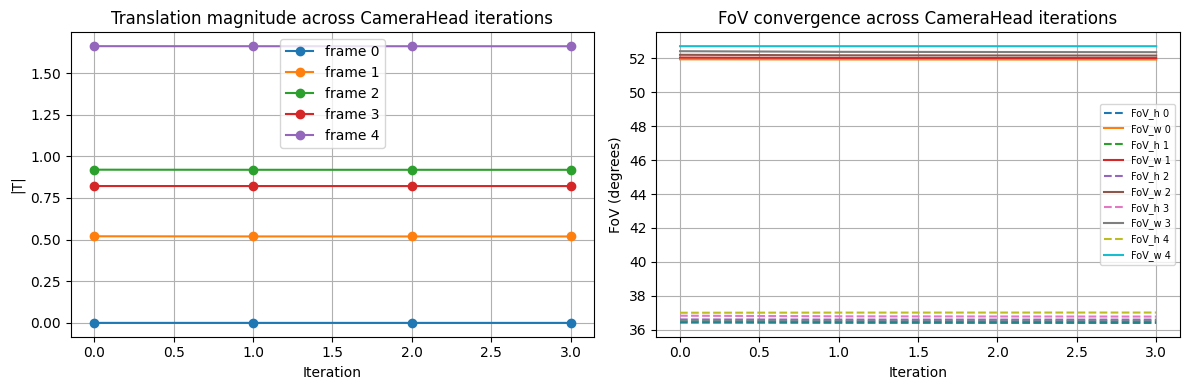

In [17]:
# Visualize CameraHead iterative refinement — capture pose_enc_list
iter_preds = predictions.get("pose_enc_list")  # list of 4 tensors [1, S, 9]

if iter_preds is not None:
    n_iters = len(iter_preds)
    # Translation magnitude across iterations for each frame
    trans_norms = torch.stack([
        p[0, :, :3].norm(dim=-1)  # [S]
        for p in iter_preds
    ]).cpu().numpy()  # [n_iters, S]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Translation norm per iteration
    for i in range(S):
        ax1.plot(range(n_iters), trans_norms[:, i], marker="o", label=f"frame {i}")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("|T|")
    ax1.set_title("Translation magnitude across CameraHead iterations")
    ax1.legend()
    ax1.grid(True)

    # FoV convergence
    fov_h = torch.stack([p[0, :, 7] for p in iter_preds]).cpu().numpy()  # [n_iters, S]
    fov_w = torch.stack([p[0, :, 8] for p in iter_preds]).cpu().numpy()
    for i in range(S):
        ax2.plot(range(n_iters), np.degrees(fov_h[:, i]), "--", label=f"FoV_h {i}")
        ax2.plot(range(n_iters), np.degrees(fov_w[:, i]), "-", label=f"FoV_w {i}")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("FoV (degrees)")
    ax2.set_title("FoV convergence across CameraHead iterations")
    ax2.legend(fontsize=7)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("pose_enc_list not in predictions — re-run the forward pass above.")

---
## 9. Thesis Notes & Summary <a id='9'></a>

### Architecture summary table

| Component | Role | Output |
|-----------|------|--------|
| **Aggregator** | DINOv2 ViT-L + cross-frame attention | 24 layers × [B, S, N, 2048] |
| **CameraHead** | 4-iter AdaLN refinement on camera token | [B, S, 9] pose_enc |
| **DPTHead (depth)** | Multi-scale FPN fusion → depth + conf | [B, S, 1, H, W] × 2 |
| **DPTHead (point)** | Multi-scale FPN fusion → world XYZ + conf | [B, S, 3, H, W] + [B, S, 1, H, W] |
| **TrackHead** | Query-point tracking (not explored here) | [B, S, N, 2] |

### Full vs No-DPT comparison

| | Full | No-DPT (camera only) |
|-|------|----------------------|
| Params | ? | ? |
| Inference time | ? | ? |
| Peak memory | ? | ? |
| Output keys | pose_enc, depth, world_points, images | pose_enc, images |

*Fill in values after running cells above.*

### Integration notes for 3D-VLA pipeline

- **Geometry features for OpenVLA**: The most useful VGGT outputs are `world_points` (dense XYZ per pixel) and `depth` — these can replace or augment 2D CLIP features in the observation encoder.
- **UNITE comparison**: VGGT gives per-frame geometry; UNITE adds semantic (CLIP + articulation) labels. The thesis combines both: VGGT for 3D structure, UNITE for semantic labeling.
- **Disable DPT for feature reuse**: With `feature_only=True` the DPT head outputs 256-d spatial features instead of final predictions — useful as an intermediate representation to feed into a custom head.
- **Camera head as free supervision**: The predicted camera poses can cross-validate against ground-truth HM3D trajectory data without extra annotation.
- **Computational budget**: No-DPT backbone runs ~?× faster — consider whether to freeze VGGT entirely or fine-tune the aggregator with a smaller LR.

---
*Fill in with observations after running experiments.*